# Product Sentiment Analysis - NLP

* Student name: Robert Cauvy 
* Student pace: Flex
* Scheduled project review date/time: 03/04/22 11:00am
* Instructor name: Claude Fried

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

![Image](images/sxsw.png)

# INTRODUCTION

Over the past decade conversations have increasingly shifted towards social media. Businesses across all industries could stand to benefit from listening to these conversations about themselves and how their products and brand are perceived by they users and prospective customers. Understanding what it is that customers enjoy the most and the least about your company's products and brand is crucial to retaining your loyal customers as well as attracting new ones.
When large companies announce their new product releases at conferences and keynotes, they can obtain useful market insights and feedback from public opinion. A great source to measure market reactions is the giant social media network, Twitter.
In addition to analyzing tweets various machine learning models will be trained and tested to classify tweets as either positive or negative sentiments towards the companies products and services. 

## Business Problem

It is not easy to obtain unbiased and unfiltered feedback and opinions from the public. Understanding how the market feels about the products and services delivered by your brand in real-time can provide valuable insights that could not get captured before the ubiquity of social media. Applying human capital to track social networks is simply not a scalable solution which makes the application of Natural Language Processing and Machine Learning classifiers well suited for this business problem. The objective of this project is provide the businesses (Apple and Google) a model that identifies which tweets hold either a positive or negative sentiment about their brand or products from a corpus of tweets. Furthermore, this project will provide the stakeholders with a list of topics and keywords that most affect public perception, leaving actionable insights for future marketing and product design decisions.


# OBTAIN

In [615]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
import string
from nltk.collocations import *
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 300)
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Data Understanding

This project is utilizing a dataset  provided by CrowdFlower to from data.world. The dataset contains over 9,000 tweets from SXSW(South by Southwest) Conference about new product releases from Apple and Google. The tweet have been labeled as to which emotion they convey towards a particular product category or company brand based off of the language contained in the tweet.

According to the provider of the dataset, humans that were tasked with labeling the sentiments of each tweet by evaluating which brand or product the tweet was about and if the tweet expressed positive, negative, or no emotion towards a brand and/or product.

In [506]:
df = pd.read_csv('data/tweet_product.csv', encoding='latin_1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [507]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [508]:
# Renaming columns to reduce verbosity
df = df.rename(columns={"tweet_text": "text", 
                   "emotion_in_tweet_is_directed_at": "product",
                  "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"
                  }
         )

In [509]:
# Cleaning up the values in sentinemts for easier interpretability

sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df.head()

,text,product,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive


In [510]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [511]:
# Create a variable "corpus" containing all text
df['text'] = df['text'].astype(str)

corpus = df['text'].to_list()

# Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

# Scrub

In [512]:
# Check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

27

In [513]:
# Take a look at duplicated records
duplicates = df.duplicated(subset=['text'], keep=False)
df.loc[duplicates.loc[duplicates==True].index].sort_values(by='text')

,text,product,sentiment
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
774,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Neutral
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Neutral
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative
8483,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative


In [514]:
# drop duplicates
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
# Check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

0

# EXPLORE

After going through some initial scrubbing of the dataset it is time to explore some of the characteristics of the tweet data. During this EDA phase, we will inspect the class balance, distribution of tweet lengths, WordClouds and most common words for each class. 

Because we are working with Twitter data, we'll work with nltk's TweetTokenizer and customize  stop words to get a better view of the content of the tweets for addressing the questions.

In [515]:
df['sentiment'].unique()

array(['Negative', 'Positive', 'Neutral', 'Unknown'], dtype=object)

In [516]:
sentiment_order = ('Negative', 'Positive',
       'Neutral', "Unknown")

sentiment_order

('Negative', 'Positive', 'Neutral', 'Unknown')

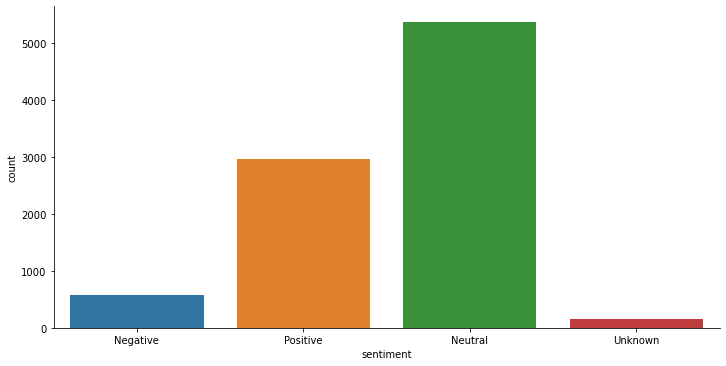

In [517]:
# Overall sentiment distribution
sns.catplot(data=df,x='sentiment',kind='count',order=sentiment_order,aspect=2);

#### Examing the class distributions

In [518]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [519]:
df['sentiment'].value_counts(normalize=True)

Neutral     0.592654
Positive    0.327377
Negative    0.062762
Unknown     0.017207
Name: sentiment, dtype: float64

Less than half of the tweets were classified as having any emotion. Of the tweets which were tagged as having an emotion, most were coded positive. About 3,000 tweets compared to only 570 tweets that were tagged as having negative emotion.

In [520]:
df[df['sentiment']=='Unknown']

,text,product,sentiment
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,NaN,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,NaN,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,NaN,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},NaN,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,NaN,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",NaN,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",NaN,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,NaN,Unknown


These tweets labeled as unknown are difficult to classify without more context and could be viewed as sarcastic.
All tweets in the corpus will need to be classified for modeling later on and the volume accounts for less than 2% of the corpus it is safe to drop these records.

In [521]:
df = df[df['sentiment']!='Unknown']
df['sentiment'].value_counts(normalize=True)

Neutral     0.603030
Positive    0.333109
Negative    0.063861
Name: sentiment, dtype: float64

Since the business problem we are looking to solve requires understanding differences between positive and negative sentiments, it is essential that positive and negative tweets are separated for the exploration process.

In [522]:
positive_df = df.loc[df['sentiment']=='Positive']
positive_df

,text,product,sentiment
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive
...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready! Stop by tomorrow to get them! #Sxsw #zazzlesxsw #sxswi {link},iPhone,Positive
9077,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,iPhone,Positive
9079,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,iPad,Positive
9085,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,iPad or iPhone App,Positive


In [523]:
negative_df = df.loc[df['sentiment']=='Negative']
negative_df

,text,product,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative
38,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,NaN,Negative
...,...,...,...
8973,"Google guy at #sxsw talk is explaining how he made realistic Twitter bots as an experiment. Gee, thanks for doing that.",NaN,Negative
8981,I think my effing hubby is in line for an #iPad 2. Can someone point him towards the line-up for wife number #2. #sxswi #sxsw,iPad,Negative
9008,I'm pretty sure the panelist that thinks &quot;Apple is drowning in their success&quot; is fucking insane. #SXSW,Apple,Negative
9043,"Hey is anyone doing #sxsw signing up for the group texting app, groupme? got it on my iphone, but no one else is on it, so....kinda useless.",NaN,Negative


In [525]:
positive_corpus = positive_df['text'].to_list()
positive_corpus[:5]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

In [524]:
negative_corpus = negative_df['text'].to_list()
negative_corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
 '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW',
 'Again? RT @mention Line at the Apple store is insane.. #sxsw']

### Tokenization

In [526]:
# Function for tokenization of tweets
def tweets_tokenize(corpus, preserve_case=False, strip_handles=True):
    
    tokenizer = TweetTokenizer(preserve_case=preserve_case, 
                               strip_handles=strip_handles)
    tokens = tokenizer.tokenize(','.join(corpus))
    
    return tokens

In [326]:
# Positive tweets tokenized
positive_tokens = tweets_tokenize(positive_corpus)

In [527]:
# Negative tweets tokenized
negative_tokens = tweets_tokenize(negative_corpus)

In [528]:
# Checking the most common positive tokens
from nltk import FreqDist
freq = FreqDist(positive_tokens)
freq.most_common(10)

[(',', 4048),
 ('#sxsw', 2981),
 ('.', 2230),
 ('the', 1590),
 ('!', 1241),
 ('link', 1214),
 ('{', 1210),
 ('}', 1210),
 ('to', 1154),
 ('at', 1019)]

In [529]:
# Checking the most common negative tokens
freq = FreqDist(negative_tokens)
freq.most_common(10)

[(',', 789),
 ('#sxsw', 568),
 ('.', 545),
 ('the', 309),
 ('to', 256),
 ('ipad', 179),
 ('"', 175),
 ('is', 159),
 ('a', 155),
 ('iphone', 145)]

Looks like there are stop words and puncuations that were tokenized and will need to be removed. 

### Lemmatization

Before removing StopWords, tokens should be lemmatized to ensure the list of words are being captured

In [530]:
# Function for lemmatizating tokens
def lemmatize_tokens(tokens_list):
    
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(word) for word in tokens_list]
    return lemma_tokens

In [531]:
# Lemmatize positive tokens
positive_tokens_lemma = lemmatize_tokens(positive_tokens)

In [532]:
# Lemmatize negative tokens
negative_tokens_lemma = lemmatize_tokens(negative_tokens)

### Punctuation And StopWord Removal

In [533]:
# Add nltk's stopwords and punctuation
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)

# Additional punctuation characters 
add_punct = ['“','”','...',"''",'’','``','']
stopword_list += add_punct

In [534]:
# Function to remove of StopWords
def stopword_removal(tokens, stopword_list=stopword_list):
    
    # Encoding tokens to remove unrecognized characters and url links
    stopped_tokens = [w.encode('ascii','ignore').decode() for w in tokens 
                      if (w not in stopword_list) & 
                      (w.startswith('http') == False)]
    
    return stopped_tokens

In [535]:
# Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [536]:
# Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [537]:
# Looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

[('#sxsw', 2981),
 ('link', 1218),
 ('ipad', 1008),
 ('rt', 929),
 ('apple', 711),
 ('google', 602),
 ('2', 593),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('sxsw', 144),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('cool', 119),
 ('free', 118),
 ("i'm", 115)]

In [538]:
# Looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

[('#sxsw', 568),
 ('ipad', 179),
 ('iphone', 145),
 ('rt', 138),
 ('google', 136),
 ('link', 103),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('ha', 31),
 ('circle', 29),
 ('design', 29),
 ('people', 29),
 ('social', 28),
 ('apps', 26),
 ('get', 25),
 ('wa', 24),
 ('austin', 23),
 ('think', 23),
 ('time', 23),
 ('launch', 22),
 ('one', 22),
 ('day', 21),
 ('today', 21),
 ('look', 21)]

In [539]:
# Appending stopwords list
stopword_list.extend(['rt','co','sxsw', '#sxsw', '#sxswi','link'])


In [540]:
# Removing StopWords from lemmatized tokens
positive_lemma_stopped = stopword_removal(positive_tokens_lemma)

In [541]:
# Removing StopWords from lemmatized tokens
negative_lemma_stopped = stopword_removal(negative_tokens_lemma)

In [542]:
# Looking at the most common tokens
freq = FreqDist(positive_lemma_stopped)
freq.most_common(30)

[('ipad', 1008),
 ('apple', 711),
 ('google', 602),
 ('2', 593),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('cool', 119),
 ('free', 118),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('today', 111)]

In [543]:
# Looking at the most common tokens
freq = FreqDist(negative_lemma_stopped)
freq.most_common(30)

[('ipad', 179),
 ('iphone', 145),
 ('google', 136),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('ha', 31),
 ('circle', 29),
 ('design', 29),
 ('people', 29),
 ('social', 28),
 ('apps', 26),
 ('get', 25),
 ('wa', 24),
 ('austin', 23),
 ('think', 23),
 ('time', 23),
 ('launch', 22),
 ('one', 22),
 ('day', 21),
 ('today', 21),
 ('look', 21),
 ('line', 20),
 ('say', 20),
 ('android', 19)]

### WordCloud Visualizations

In [544]:
# Writing a function to generate wordcloud
def wordcloud_generator(tokens, collocations=False, background_color='black', 
                       colormap='Greens', display=True):

    
    # Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    # Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
        
    return wordcloud

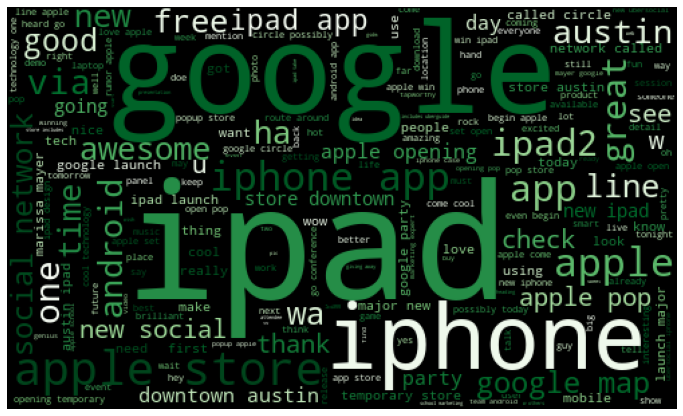

In [545]:
# Generate a WordCloud for positive tweets
positive_cloud = wordcloud_generator(positive_lemma_stopped, collocations=True)

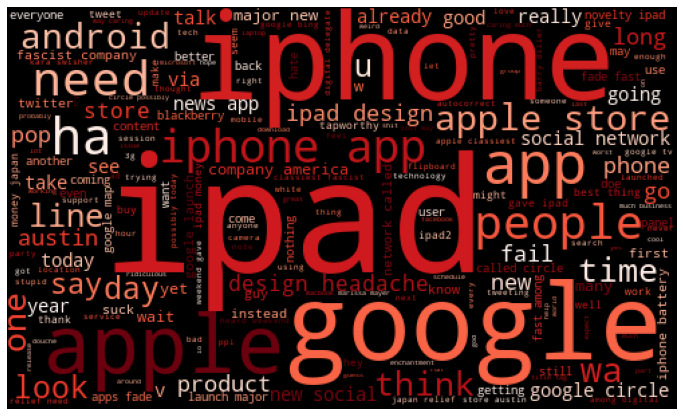

In [546]:
# Generate a WordCloud for negative tweets
negative_cloud = wordcloud_generator(negative_lemma_stopped, colormap='Reds',
                                     collocations=True)

In [547]:
# Generate a wordcloud comparison of negative and positive tweets
def wordcloud_comp(wc1, wc2):
 
    fig, ax = plt.subplots(figsize=(16,20), ncols=2)
    title_font = {'fontweight':'bold','fontsize':20}
    sentiment = 'Positive'
    ax[0].imshow(wc1)
    ax[0].set_title(sentiment,fontdict=title_font)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    sentiment = 'Negative'
    ax[1].imshow(wc2)
    ax[1].set_title(sentiment,fontdict=title_font)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.tight_layout();
    

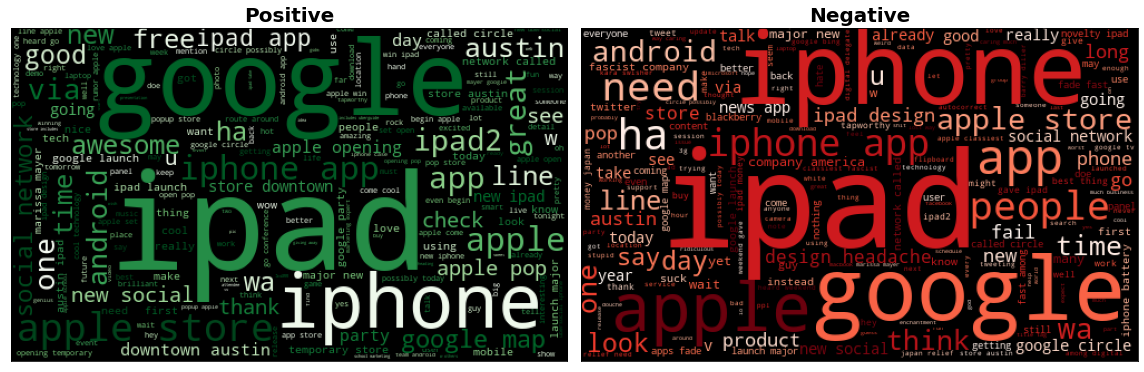

In [548]:
wordcloud_comp(positive_cloud, negative_cloud)

It looks like the brands presenting new services and  and product launches at the event appeared most in both positive and negative tweets. Let's look at WordClouds with those words added to the stop list.

In [549]:
# Removing brands and products from the Wordcloud
stopword_list_no_brands = stopword_list + ['ipad', 'ipad2','#ipad2','apple', 'google', 'iphone', 
                           '#apple','#google', '#ipad', '#iphone', 'android']

positive_stopped_brands = stopword_removal(positive_tokens_lemma, stopword_list=stopword_list_no_brands)

In [550]:
negative_stopped_brands = stopword_removal(negative_tokens_lemma, stopword_list=stopword_list_no_brands)

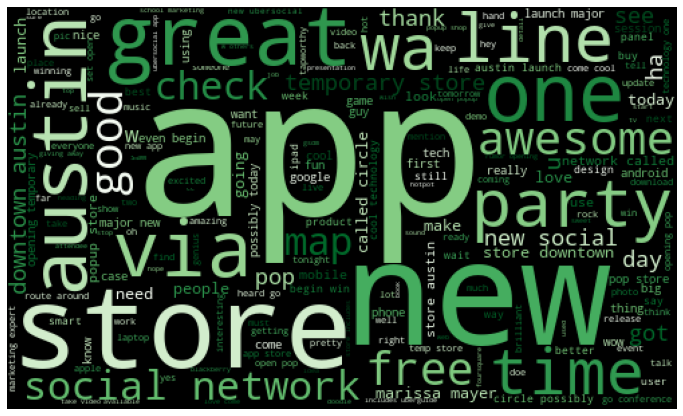

In [551]:
positive_cloud_no_names = wordcloud_generator(positive_stopped_brands, collocations=True)

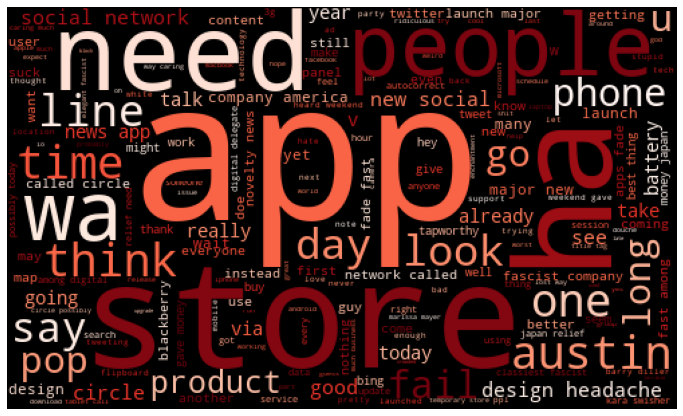

In [552]:
negative_cloud_no_names = wordcloud_generator(negative_stopped_brands, 
                                              colormap='Reds',collocations=True)

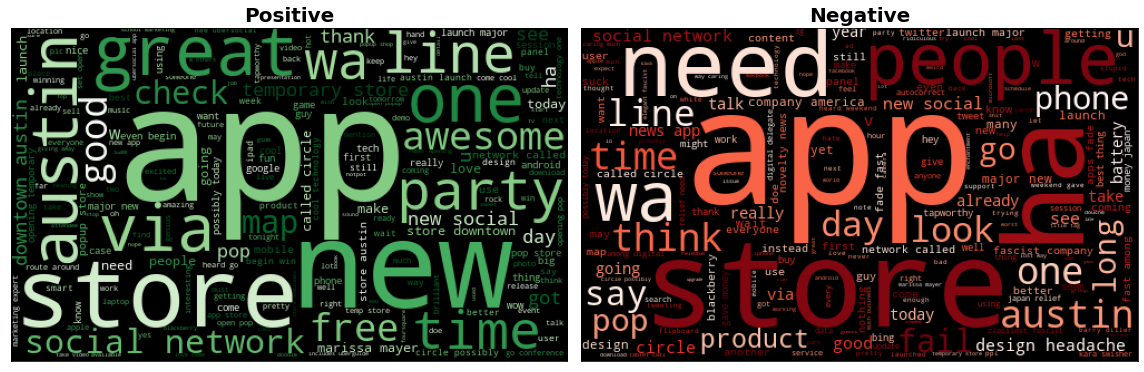

In [553]:
wordcloud_comp(positive_cloud_no_names,negative_cloud_no_names)

###  Tweet Bigrams

In [554]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [555]:
positive_finder = BigramCollocationFinder.from_words(positive_lemma_stopped)
negative_finder = BigramCollocationFinder.from_words(negative_lemma_stopped)

In [556]:
pos_bigrams = positive_finder.score_ngrams(bigram_measures.raw_freq)
neg_bigrams = negative_finder.score_ngrams(bigram_measures.raw_freq)

In [557]:
# Creating a DataFrame from the positive bigrams
pos_bigrams_df = pd.DataFrame(pos_bigrams, columns=["Word","Freq"]).head(10)

In [558]:
# Creating a DataFrame from the negative bigrams
neg_bigrams_df = pd.DataFrame(neg_bigrams, columns=["Word","Freq"]).head(10)

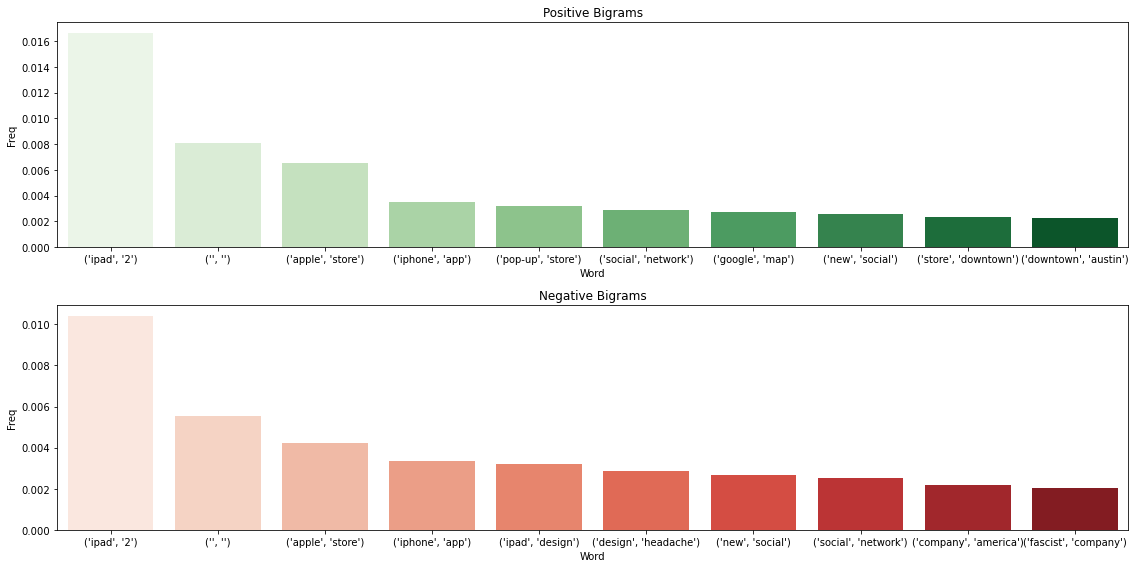

In [559]:
# Plotting Bi-grams
fig, axes = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(data=pos_bigrams_df, x=pos_bigrams_df['Word'],
            y=pos_bigrams_df['Freq'],ax=axes[0],palette='Greens')
sns.barplot(data=neg_bigrams_df, x=neg_bigrams_df['Word'], 
            y=neg_bigrams_df['Freq'],ax=axes[1],palette='Reds')
axes[0].set_title('Positive Bigrams')
axes[1].set_title('Negative Bigrams')
plt.tight_layout();

### Exploring Sentiments of Products/Services

In [561]:
df['product'].value_counts()

iPad                               939
Apple                              657
iPad or iPhone App                 469
Google                             427
iPhone                             295
Other Google product or service    292
Android App                         80
Android                             77
Other Apple product or service      35
Name: product, dtype: int64

In [562]:
product_order = ['iPad','Apple','iPad or iPhone App','Google','iPhone',
                 'Other Google product or service','Android App','Android',
                 'Other Apple product or service']

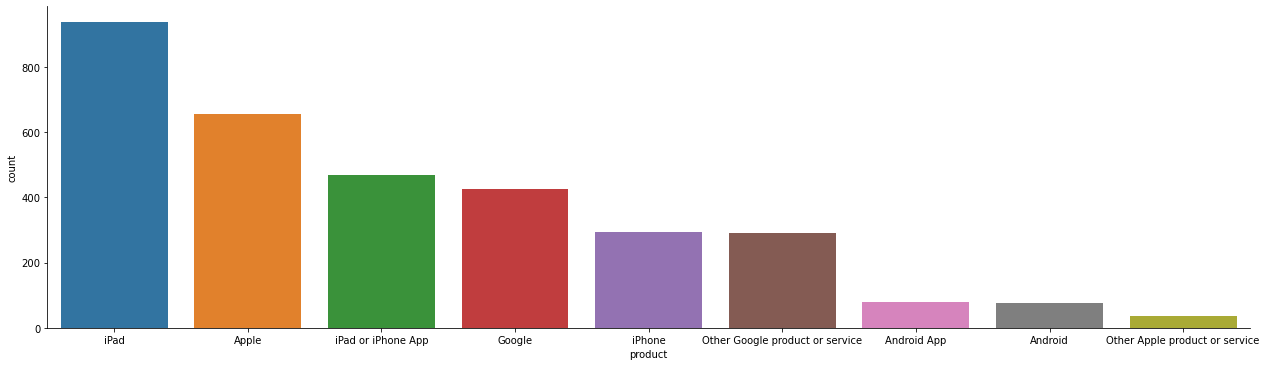

In [563]:
# Product tweet distribution
sns.catplot(data=df,x='product',kind='count',order=product_order,aspect=3.5);

In [564]:
# Mapping products and services to their brand
product_dict={'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
              'Google': 'Google', 'iPhone': 'Apple', 
              'Other Google product or service': 'Google',
              'Android App': 'Google', 'Android': 'Google',
              'Other Apple product or service': 'Apple'}

df['brand'] = df['product'].map(product_dict)

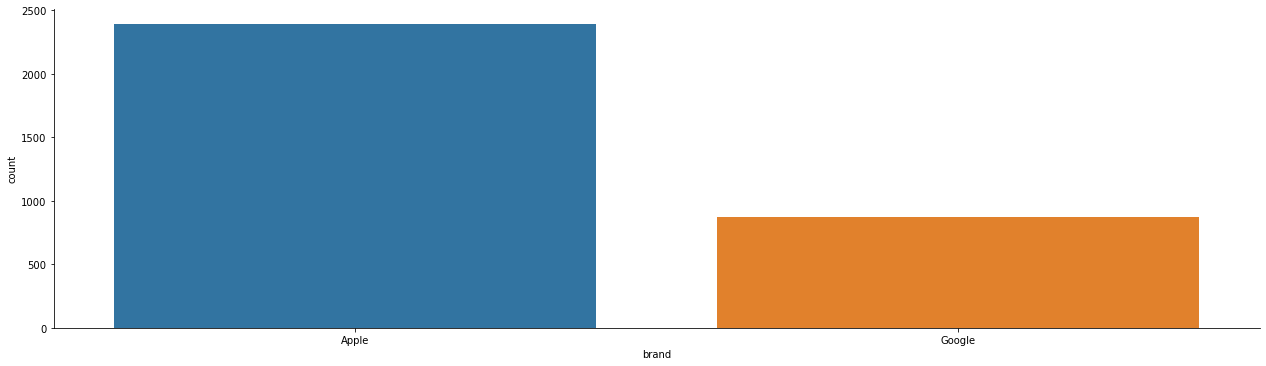

In [565]:
# Brand tweet distribution
sns.catplot(data=df,x='brand',kind='count',order=['Apple', 'Google'],aspect=3.5);

In [628]:
df.groupby(['brand','product','sentiment']).count()

text
brand  product                         sentiment      
Apple  Apple                           Negative     95
                                       Neutral      21
                                       Positive    541
       Other Apple product or service  Negative      2
                                       Neutral       1
                                       Positive     32
       iPad                            Negative    125
                                       Neutral      24
                                       Positive    790
       iPad or iPhone App              Negative     63
                                       Neutral      10
                                       Positive    396
       iPhone                          Negative    102
                                       Neutral       9
                                       Positive    184
Google Android                         Negative      8
                                       Neutral       1
                                       Positive     68
       Android App                     Negative      8
                                       Neutral       1
                                       Positive     71
       Google                          Negative     68
                                       Neutral      15
                                       Positive    344
       Other Google product or service Negative     47
                                       Neutral       9
                                       Positive    236

# MODEL

## Preprocessing For Modeling

Since the business problem is only concerned with classifying tweets as negative or positive a binary classification model will be employed. Therefore we are going to be developing a model for binary classification, we need to binarize the target column, which in this case in the 'sentiment' column. 

In [568]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Name: sentiment, dtype: int64

In [569]:
# create X and y from only tweets labeled as having a positive or negative sentiment
X = df.loc[df['sentiment'].isin(['Positive', 'Negative']), 
           'text']
y = df.loc[df['sentiment'].isin(['Positive', 'Negative']), 
           'sentiment']

In [570]:
# Dicts to transform labels into binary
binary_key = {'Negative':1, 'Positive': 0}

# Map class labels to binary
y = y.map(lambda x: binary_key[x])
y.value_counts()

0    2968
1     569
Name: sentiment, dtype: int64

In [571]:
classes = ['Positive', 'Negative']

### Classification Evaluator

In [572]:
def clf_eval(X_test, y_test, X_train, y_train, clf, score='macro recall', 
             labels=classes):
    
    test_preds = clf.predict(X_test)
    train_preds = clf.predict(X_train)
   
    spacer = '-' * 50
    
    print('\n')
    print('Training Data')
    print(spacer)
    print(classification_report(y_train, train_preds))
    print('\n')
    print('Test Data')
    print(spacer)
    print(classification_report(y_test, test_preds))
    print()
    
    print(f'Training Score: {round(clf.score(X_train, y_train),2)}')
    print(f'Test Score:{round(clf.score(X_test, y_test),2)}')

    


    auc = np.round(roc_auc_score(y_test, test_preds), 2)

    fig, axes = plt.subplots(figsize=[8, 3], nrows=1, ncols=2)
    fig.tight_layout()
    plot_confusion_matrix(clf, X_test, y_test, normalize='true', 
                          display_labels=labels, cmap='Blues', ax=axes[0])
    plot_roc_curve(clf, X_test, y_test, ax=axes[1])
    axes[1].legend(loc='best', fontsize='small', labels=[f'AUC: {auc}'])
    axes[1].plot([0,1], [0,1], ls='--', color='orange')

    
    plt.show()
        
    
    return None
        

### Train Test Split

In [573]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2829
2829
708
708


In [574]:
y_train.value_counts(normalize=True)

0    0.839166
1    0.160834
Name: sentiment, dtype: float64

In [575]:
y_test.value_counts(normalize=True)

0    0.838983
1    0.161017
Name: sentiment, dtype: float64

### Text Preprocessing Pipeline

In [576]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

In [577]:
preprocess_pipe = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer.tokenize,
                                   stop_words=stopword_list)),
    ('transformer', TfidfTransformer())
])

### Baseline Classification Model

Baseline model will be used to measure how well our model performs compared to random guessing.



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2374
           1       0.16      0.16      0.16       455

    accuracy                           0.73      2829
   macro avg       0.50      0.50      0.50      2829
weighted avg       0.73      0.73      0.73      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       594
           1       0.22      0.23      0.23       114

    accuracy                           0.75       708
   macro avg       0.54      0.54      0.54       708
weighted avg       0.75      0.75      0.75       708


Training Score: 0.73
Test Score:0.75


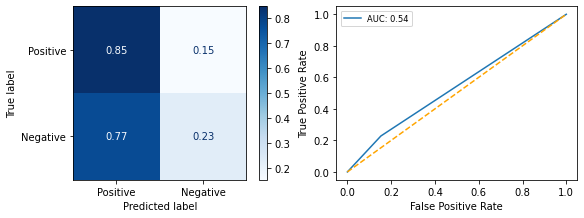

In [578]:
clf_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('clf', DummyClassifier(random_state=42, strategy='stratified'))
])

clf_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, clf_pipe, labels=classes)

The dummy classifier is correctly predicting 83% of the "Positive" tweets. This demonstrates a class imbalance with the "Positive" tweets representing the majority class.



### Dummy Classifier with ROS



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.50      0.63      2374
           1       0.16      0.50      0.24       455

    accuracy                           0.50      2829
   macro avg       0.50      0.50      0.44      2829
weighted avg       0.73      0.50      0.57      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.49      0.61       594
           1       0.14      0.43      0.21       114

    accuracy                           0.48       708
   macro avg       0.48      0.46      0.41       708
weighted avg       0.71      0.48      0.55       708


Training Score: 0.5
Test Score:0.48


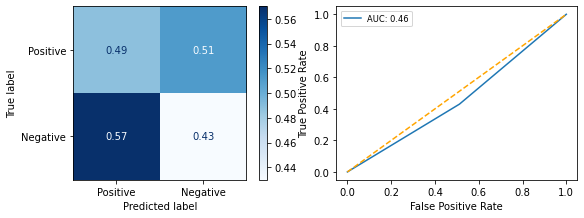

In [579]:
clf_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                   stop_words=stopword_list)),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', DummyClassifier(random_state=42,strategy='stratified'))
])
clf_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, clf_pipe)

To address the class imbalance, the tweets can be randomly oversampled. Because this technique will be used in the modeling steps below it can serve a good starting point. The ROS did help balance out the True Negative rate which increased up to 50%.

## Multinomial Naive Bayes


### Tfidf Standardized Document  Term Matrix

In [580]:
mnb_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                   stop_words=stopword_list)),
    ('clf', MultinomialNB())
])



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2374
           1       1.00      0.15      0.26       455

    accuracy                           0.86      2829
   macro avg       0.93      0.57      0.59      2829
weighted avg       0.88      0.86      0.82      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       594
           1       0.73      0.07      0.13       114

    accuracy                           0.85       708
   macro avg       0.79      0.53      0.52       708
weighted avg       0.83      0.85      0.79       708


Training Score: 0.86
Test Score:0.85


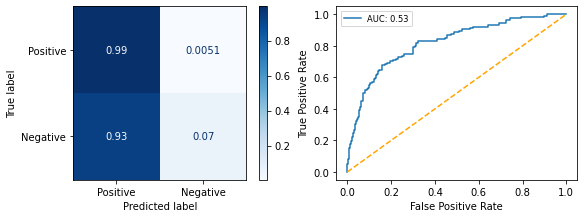

In [581]:
mnb_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, mnb_text_pipe)

The vanilla Multinomial Bayes model performs even worse than the dummy classifier predicting every tweet as the majority class.

### Counted Document  Term Matrix

In [582]:
mnb_text_pipe = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenizer.tokenize,
                                   stop_words=stopword_list)),
    ('clf', MultinomialNB())
])



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2374
           1       0.94      0.75      0.84       455

    accuracy                           0.95      2829
   macro avg       0.95      0.87      0.90      2829
weighted avg       0.95      0.95      0.95      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       594
           1       0.69      0.32      0.44       114

    accuracy                           0.87       708
   macro avg       0.78      0.65      0.68       708
weighted avg       0.85      0.87      0.85       708


Training Score: 0.95
Test Score:0.87


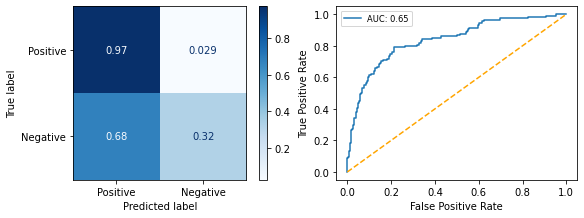

In [583]:
mnb_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, mnb_text_pipe)

The bag of words vectorizer works better than the Tfidf when performed with minimal processing (no stemming or lemmatizing and no stopword or punctuation removal, but it is still under performing on test data with just 32% recall on the Negative class. The training score is also higher than the testing score showing that it is overfit. Tdidf vectorizing will be used again in model iterations below after further process the text.

### Tuning MNB with GridSearchCV

In [584]:
params = {'clf__alpha': [0.001, 0.01, 0.1, 1],
        'vectorizer__stop_words': [stopword_list, 'english']}

gs = GridSearchCV(mnb_text_pipe, param_grid=params, 
                              scoring='recall_macro')

gs.fit(X_train,  y_train)
gs.best_params_

{'clf__alpha': 0.1, 'vectorizer__stop_words': 'english'}

The customized stopwords list performed better than the default 'english' stopwords list. and the learning rate of 0.1 was the best value of all the learning rates tried. Let's try these parameters in a new model.



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2374
           1       0.99      0.90      0.94       455

    accuracy                           0.98      2829
   macro avg       0.98      0.95      0.97      2829
weighted avg       0.98      0.98      0.98      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       594
           1       0.70      0.37      0.48       114

    accuracy                           0.87       708
   macro avg       0.79      0.67      0.71       708
weighted avg       0.86      0.87      0.86       708


Training Score: 0.98
Test Score:0.87


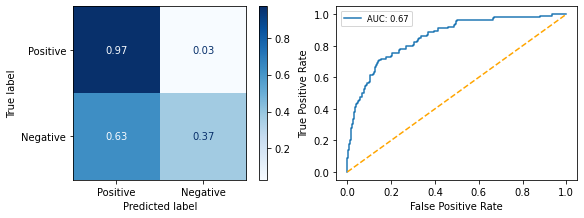

In [585]:
tuned_mnb_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words='english')), 
    ('clf', MultinomialNB(alpha=0.01))
])

tuned_mnb_text_pipe.fit(X_train, y_train)


clf_eval(X_test, y_test, X_train, y_train, tuned_mnb_text_pipe, labels=classes)

The model correctly classified 35% of the negative tweets. The gridsearch imporved the TN rate form 0%. The model is slightly overfitted to the training data. Using the ROS again could help level out the class imbalance.

### MNB with ROS



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2374
           1       0.90      0.97      0.93       455

    accuracy                           0.98      2829
   macro avg       0.95      0.97      0.96      2829
weighted avg       0.98      0.98      0.98      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       594
           1       0.53      0.60      0.56       114

    accuracy                           0.85       708
   macro avg       0.72      0.75      0.73       708
weighted avg       0.86      0.85      0.85       708


Training Score: 0.98
Test Score:0.85


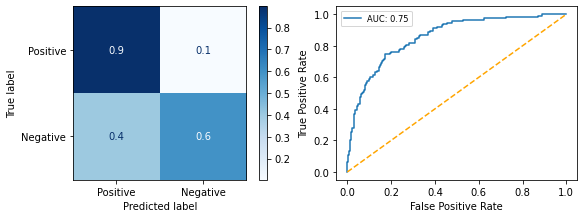

In [586]:
ros_mnb_text_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words='english')),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

ros_mnb_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, ros_mnb_text_pipe, labels=classes)

This is the best performing iteration yet. The gridsearch improved this model to correctly predict 54% of the Negative tweets. When comparing to the baseline the TP for the Negative Tweets went up by 8%. Still not the best results as its still fairly low and the model continues to overfit to the training data. 

### Tuning Oversampled MNB with GS

In [587]:
params = {'clf__alpha': [0.001, 0.01, 0.1, 1],
        'vectorizer__stop_words': [stopword_list, stopword_list_no_brands, 'english']}

gs = GridSearchCV(mnb_text_pipe, param_grid=params, 
                              scoring='recall_macro')

gs.fit(X_train,  y_train)
gs.best_params_

{'clf__alpha': 0.1, 'vectorizer__stop_words': 'english'}

Now after girdsearching best parameters for the ROS the alpha value of 1 and the default stopword list were returned as the best parameters.





Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2374
           1       0.77      0.96      0.86       455

    accuracy                           0.95      2829
   macro avg       0.88      0.95      0.91      2829
weighted avg       0.96      0.95      0.95      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       594
           1       0.47      0.68      0.56       114

    accuracy                           0.82       708
   macro avg       0.70      0.77      0.72       708
weighted avg       0.86      0.82      0.84       708


Training Score: 0.95
Test Score:0.82


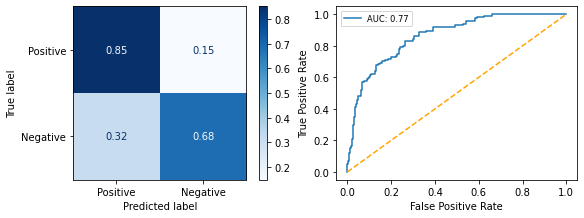

In [588]:
tuned_ros_mnb_text_pipe = imblearn.pipeline.Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words='english')),
    ('os', RandomOverSampler(random_state=42)),
    ('clf', MultinomialNB(alpha=1))
])

tuned_ros_mnb_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, tuned_ros_mnb_text_pipe, labels=classes)

Fitting the model to the newly tuned parameters, it once again saw an improvement to correctly identifying Negative tweets at an increased rate of 62% up from 54%. This increased performance does however come at a cost in predictions for the majority class are down to 87% from the previous 90%. This was to be expected since it was optimized for the recall macro score which topped out at an average score of 0.75, much improved from the dummy baseline of 0.49.

## Logistic Regression

After iterating on several Multinomial Naive Bayes models, let's try another easily interpretable classification model that accepts an argument for class_weight, Logistic Regression.

In [589]:
lr_text_pipe = Pipeline([('vectorizer',
                          TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                          stop_words=stopword_list)),
                         ('clf', LogisticRegressionCV(class_weight='balanced',
                                                      random_state=42,
                                                      n_jobs=-1, cv=3))
])



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       0.99      1.00      1.00       455

    accuracy                           1.00      2829
   macro avg       1.00      1.00      1.00      2829
weighted avg       1.00      1.00      1.00      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       594
           1       0.62      0.54      0.58       114

    accuracy                           0.87       708
   macro avg       0.77      0.74      0.75       708
weighted avg       0.87      0.87      0.87       708


Training Score: 1.0
Test Score:0.87


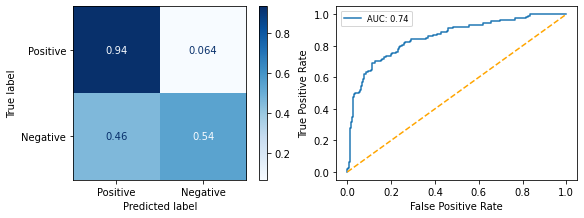

In [590]:
lr_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, lr_text_pipe)

The first iteration of the Logistic Regression model accurately classified 50% of the Negative tweets and 92% of the Positive tweets. The average recall macro score result of 0.71 is not too bad for the first pass. Next we'll tune the hyperparameters with GridsearchCV to see if this score can be improved.

### Tuning Logistic Regression with GridSearchCV

In [591]:
params = {'clf__class_weight': ['balanced'],
          'clf__max_iter': [100, 500, 1000],
          'clf__Cs': [[0.01], [0.1], [1]],
          'clf__solver': ['liblinear', 'lbfgs', 'sag', 'saga']}

gs = GridSearchCV(estimator=lr_text_pipe, param_grid = params,
                  scoring='recall_macro')

gs.fit(X_train,  y_train)
gs.best_params_

{'clf__Cs': [1],
 'clf__class_weight': 'balanced',
 'clf__max_iter': 100,
 'clf__solver': 'liblinear'}

### Tuned LR Model

In [592]:
# Iterating the model with the best parameters returned from the gridsearch
tuned_lr_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', LogisticRegressionCV(solver='liblinear',
                                 max_iter=100, 
                                 class_weight='balanced',
                                 Cs=1,
                                 random_state=42,
                                 n_jobs=-1))
])



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2374
           1       0.51      0.84      0.64       455

    accuracy                           0.85      2829
   macro avg       0.74      0.84      0.77      2829
weighted avg       0.89      0.85      0.86      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       594
           1       0.39      0.64      0.48       114

    accuracy                           0.78       708
   macro avg       0.65      0.72      0.67       708
weighted avg       0.84      0.78      0.80       708


Training Score: 0.85
Test Score:0.78


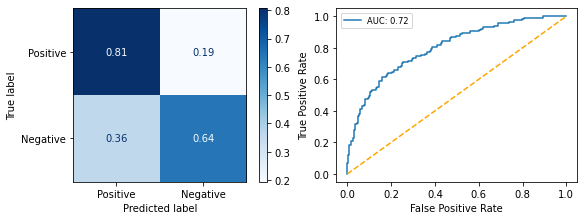

In [599]:
tuned_lr_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, tuned_lr_text_pipe)

The hyperparameter tuned model performed  11% better compared to vanilla logistic regression model at classifying the Negative tweets, but the average recall macro score was unchanged. There is also still the problem of overfitting to the training data. So far the the tuned MNB with ROS is performing the best. 

## Random Forest

The next classifier we'll test is Random Forest. This was chosen because like Logistic Regression, it is highly interpretably and also takes the class_weight argument to help address the class imbalance without using the Random Over Sampler.

In [593]:
rf_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)), 
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2374
           1       0.99      1.00      1.00       455

    accuracy                           1.00      2829
   macro avg       1.00      1.00      1.00      2829
weighted avg       1.00      1.00      1.00      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       594
           1       0.83      0.26      0.40       114

    accuracy                           0.87       708
   macro avg       0.85      0.63      0.66       708
weighted avg       0.87      0.87      0.84       708


Training Score: 1.0
Test Score:0.87


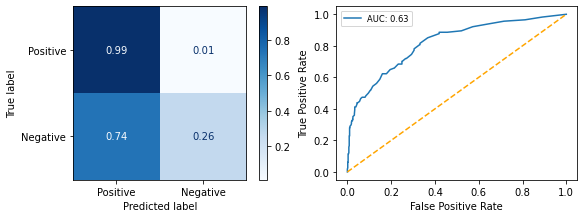

In [594]:
rf_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, rf_text_pipe)

The Random Forest model initially performs like the baseline models above. It identifies all the positive tweets but only correctly classifies the negative tweets at a rate of 24% which is not great. The following iterations will attempt to improve. Also, the training score is slightly higher than the testing score meaning the model is likely overfit to the training data. 

### Tuning Random Forest With GridsearchCV

In [595]:
params = {'clf__criterion': ['gini', 'entropy'],
          'clf__max_depth': [10, 20, None],
          'clf__min_samples_leaf': [1, 2, 3]}

gs = GridSearchCV(estimator=rf_text_pipe, param_grid = params, 
                              scoring='recall_macro', n_jobs=-1)

gs.fit(X_train, y_train)
gs.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 2}

### Tuned RF Model



Training Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      2374
           1       0.43      0.80      0.56       455

    accuracy                           0.80      2829
   macro avg       0.69      0.80      0.71      2829
weighted avg       0.87      0.80      0.82      2829



Test Data
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       594
           1       0.35      0.57      0.43       114

    accuracy                           0.76       708
   macro avg       0.63      0.68      0.64       708
weighted avg       0.82      0.76      0.78       708


Training Score: 0.8
Test Score:0.76


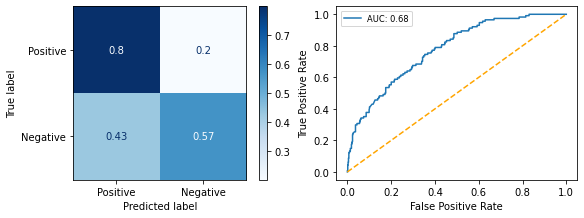

In [596]:
tuned_rf_text_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   stop_words=stopword_list)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, 
                                   criterion='entropy', max_depth=10, 
                                   min_samples_leaf=3))
])

tuned_rf_text_pipe.fit(X_train, y_train)

clf_eval(X_test, y_test, X_train, y_train, tuned_rf_text_pipe)

Hyperparameter tuning dramatically improved the the model when classifying the Negative tweets 61% which is improved by 37% when compared to the previously untuned vanilla Random Forest model. The trade off here is the rate at which the model correctly predicted the Positive tweets decreased to 74% from the previous model's 99%.

# Interpreting Results

While iterating the classification models above, they were tuned to optimize the  recall macro so that no one class performs much better than the other.

The best performing models were the hyperparameter tuned RandomOverSampled Multinomial Naive Bayes model based off an average recall macro score of 0.75. 
The next best performance was from the tuned logistic regression model with a recall macro score of 0.72.
Ultimately it can determined that the tuned logistic regression model can be selected as the best even though the accuracy score was 0.79 compared to the MNBayes 0.84. A 0.79 accuracy score on the testing data shows that it correctly classified the tweets as having positive or negative sentiments at a rate of 79%. Not a bad score for this metric, however this model (along with all the other classifiers and iterations) was better at predicting the majority class (Positive tweets) than it was at identifying the tweets with negative sentiment. 38% of the negative tweets were incorrectly categorized as positive and 19% of the positive tweet were misclassified as being negative. All of these metric scores outperform the baseline model. 

### Best Model

In [633]:
def plot_importances(clf_pipe, n_features, title):
   
    feats = clf_pipe['vectorizer'].get_feature_names()
    coefs = clf_pipe['clf'].coef_[0]
    
    importance_df = pd.DataFrame(feats, columns=['Word'])
    importance_df['Importance'] = math.e**(abs(coefs))
    importance_df['Coefficient'] = coefs

    feat_importance = importance_df.sort_values(
        by = ["Importance"], ascending=False).head(n_features)
    
    fig, ax= plt.subplots(figsize=(12,6))
    ax.set_title(f'Coefficients for {title}')
    ax.set_ylabel('Word')
    ax.set_xlabel('Coefficient')
    sns.barplot(x='Coefficient', y='Word', palette='magma', 
                data=feat_importance, ax=ax)


    plt.tight_layout();

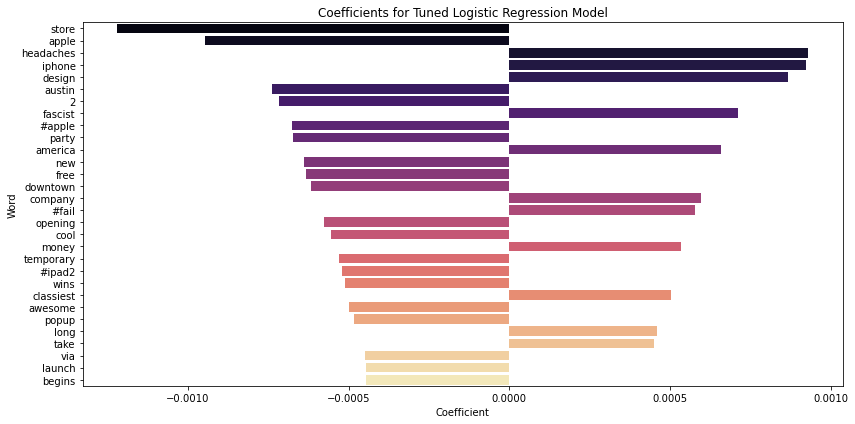

In [634]:
plot_importances(tuned_lr_text_pipe, 30, 'Tuned Logistic Regression Model')

The left graph plotted above shows how the words in the tweet affects the model's classification. For example if words such store, Apple, and pop-up were contained in the tweet it was more likely to be categorized as positive while on the other hand if the tweet contained words such iphone, headache, design and battery led the model to predict it as having a negative sentiment. The OverSampled Multinomial Naive Bayes model is showed that there were several words that carried significance to the model so it is difficult to distinguish what the top features. Let's try to extract coefficients from the other top performing models.

# CONCLUSIONS & RECOMMENDATIONS

It is increasingly important for brands to be listening to how the the public perceives them and a great way to do so is through the use of social media platforms. The objective of this project was to examine labeled twitter data and explore the possibility of leveraging machine learning to predict sentiment from twitter data. This tool can be used by stakeholders to monitor their competition and get unbiased customer feedback for their new product releases. Considering not even humans can properly identify twitter sentiments 100% of the time, ~80% accuracy score from the machine learning models based of a relatively small dataset is an acceptable score and requires significantly less resource than if this task was to be completed by humans. I do believe this model demonstrates that a less complex, interpretable models like a Logistic Regression can be trained on labeled data to predict sentiment more accurately than random guessing. The ease of interpretation of Logistic Regression models 
Since the Logistic Regression models are easy to interpret it can offer actionable insights to business stakeholders by informing future marketing strategy and product design. Going forward, the biggest challenge would be adding to the corpus with accurately labeled data to continually train the model.

## Recommendations & Next Steps

As was discovered from  both the exploration and modeling phase a lot of the negative sentiment were focused on the headaches from the design, the battery of the iPhone and the associated prices. The recommendations from the negative feedback is to improve the battery life and improve on the product design. Alternatively, it would appear that the pop-up store in the downtown Austin area was very well received and should be further looked into for generating buzz at other locations during new product releases. The terms 'party' and 'free' were also linked to positive tweets about the brands. The marketing team should look to plan other events with giveaways at future conferences.

The greatest limitation to this project was the size of the dataset. The data started with 9,092 records, which is not the largest mount of data to begin with. It was then later reduced down to 3,537 after dropping the tweets with neither a positive or negative sentiment that was needed for classify into a binary target variable. There was also a significant class imbalance, where only 569 tweets or about 16% of the remaining data were labeled as having negative sentiment. I would imagine that the business stakeholders of this project would be more interested in the tweets labeled as negative from both their brand and products and that if their competitors since it leads to more actionable insights.

After the size of the dataset, another limitation of this project was the target variable was a binary classification where in the real-world a multi-class model could be more useful to identify whether tweets have a positive, negative or neutral sentiment, even though the neutral tweets will not be as useful for extracting insights. 
The next step to this project after collecting more labeled data would be to train more complex models and other deep NLP techniques like a word2vec vecotrizer, and neural networks. Even though  those models may be less interpretable, it should have a higher performance score that can be used in tandem with the successful models used here to extract coefficients. 